In [1]:
using PauliPropagation
using Plots
using Logging
using Statistics
using GLM
using DataFrames
using StatsModels
using Formatting

In [2]:


################# Logging Setup ####################
struct UnbufferedLogger <: Logging.AbstractLogger
    stream::IO
    level::Logging.LogLevel
end

const ImportantInfo = Base.CoreLogging.LogLevel(300)
const MainInfo = Base.CoreLogging.LogLevel(200)
const SubInfo = Base.CoreLogging.LogLevel(100)
const SubsubInfo = Base.CoreLogging.LogLevel(50)

const LOG_LEVEL_NAMES = Dict(
    Logging.Debug => "Debug",
    Logging.Info => "Info",
    Logging.Warn => "Warn",
    Logging.Error => "Error",
    SubInfo => "SubsubInfo",
    SubInfo => "SubInfo",
    MainInfo => "MainInfo",
    ImportantInfo => "ImportantInfo"
)

Logging.min_enabled_level(logger::UnbufferedLogger) = logger.level
Logging.shouldlog(logger::UnbufferedLogger, level, _module, group, id) = level ≥ logger.level
Logging.catch_exceptions(::UnbufferedLogger) = true

function Logging.handle_message(logger::UnbufferedLogger, level, message, _module, group, id, file, line; kwargs...)
    level_name = get(LOG_LEVEL_NAMES, level, "$level")  # Default for custom levels
    print(logger.stream, "[$level_name] ", message, "\n")  # Include log level
    flush(logger.stream)  # Ensure immediate output
end

#################### Structure and Setup ####################
struct trotter_ansatz_tfim
    target_circuit::Vector{Gate}
    target_circuit_layer::Vector{Gate}
    topology::Vector{Tuple{Int64, Int64}}
    nqubits::Integer
    steps::Integer #layers
    time::Float64
    J::Float64
    h::Float64
    sigma_J::Float64
    sigma_h::Float64
    sigma_J_indices::Vector{Int64}
    sigma_h_indices::Vector{Int64}
    sigma_J_indices_layer::Vector{Int64}
    sigma_h_indices_layer::Vector{Int64}
end

function trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64;topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = tfitrottercircuit(nqubits,steps,topology=topology) #starts with RZZ layer
    target_circuit_layer = tfitrottercircuit(nqubits,1,topology=topology) #starts with RZZ layer
    sigma_J = -2*time*J/steps
    sigma_h = 2*time*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
    return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end

function constrain_params(ansatz; layer=false)
    """
    Set all RX gates and all RZZ gates to have the same parameter value respectively.
    """
    if layer
        nparams = countparameters(ansatz.target_circuit_layer)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices_layer] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices_layer] .= ansatz.sigma_J
    else
        nparams = countparameters(ansatz.target_circuit)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices] .= ansatz.sigma_J
    end
    
    return thetas
end

function obs_interaction(ansatz)
    interaction = PauliSum(ansatz.nqubits)
    
    for i in 1:length(ansatz.topology)
        q1 = ansatz.topology[i][1]
        q2 = ansatz.topology[i][2]
        add!(interaction, [:Z, :Z], [q1, q2])
    end
    return wrapcoefficients(interaction/length(ansatz.topology), PauliFreqTracker)
end

function obs_magnetization(ansatz)
    """
    Returns the normalised magnetization.
    """
    magnetization = PauliSum(ansatz.nqubits)
    for i in 1:ansatz.nqubits
        add!(magnetization,:Z,i)
    end
    magnetization = magnetization/ansatz.nqubits
    return wrapcoefficients(magnetization, PauliFreqTracker)
end


function trotter_time_evolution(ansatz; observable = nothing, special_thetas=nothing, noise_kind="noiseless", record=false, min_abs_coeff=0.0, max_weight=Inf, max_freq=Inf, max_sins=Inf, depol_strength=0.01, dephase_strength=0.01,depol_strength_double=0.0033, dephase_strength_double=0.0033) 
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    if observable==nothing
        obs = obs_interaction(ansatz)
    else
        obs = deepcopy(observable)
    end

    if special_thetas==nothing
        thetas = constrain_params(ansatz)
    else
        thetas = special_thetas
    end

    if noise_kind=="naive"
        if record
            error("Naive noise model doesn't support recording :(")
        else
            circuit = final_noise_layer_circuit(ansatz; depol_strength, dephase_strength)
        end
    elseif noise_kind=="gate"
        circuit = gate_noise_circuit(ansatz; depol_strength, dephase_strength, layer=record)
    elseif noise_kind=="noiseless"
        if record
            circuit = ansatz.target_circuit_layer
        else
            circuit = ansatz.target_circuit
        end
    elseif noise_kind=="realistic"
        circuit = realistic_gate_noise_circuit(ansatz; depol_strength_single = depol_strength, dephase_strength_single = dephase_strength, depol_strength_double = depol_strength_double, dephase_strength_double = dephase_strength_double, layer=record)
        
    else
        error("Noise kind $(noise_kind) unknown.")
    end

    if record
        nparams = countparameters(ansatz.target_circuit)
        expvals_trotter = Float64[]   
        push!(expvals_trotter, overlapwithzero(obs))
        for i in 1:ansatz.steps
            psum = propagate!(circuit, obs, thetas[Int(nparams/ansatz.steps*(i-1)+1):Int(nparams/ansatz.steps*i)];min_abs_coeff=min_abs_coeff)
            push!(expvals_trotter, overlapwithzero(psum))
        end
        return expvals_trotter  
    else 
        psum = propagate!(circuit, obs, thetas; min_abs_coeff=min_abs_coeff, max_weight=max_weight, max_freq=max_freq, max_sins=max_sins)
        return overlapwithzero(psum)
    end
end

trotter_time_evolution (generic function with 1 method)

In [3]:

function full_run(ansatz; min_abs_coeff = 0.0, observable = nothing, record = false, cdr_method = "end")
    """
    """
    @logmsg SubInfo "ready to ruuuuuummmble"


    if observable==nothing || observable == obs_interaction(ansatz)
        observable = obs_interaction(ansatz)
        obs_string = "ZZ"
    elseif observable == obs_magnetization(ansatz)
        obs_string = "Z"
    end


    time1 = time()
    exact_expval_target = trotter_time_evolution(ansatz; observable = observable, min_abs_coeff = min_abs_coeff_target, record = record) #should be close to one as we stay in FM phase
    timetmp1 = time()
    @logmsg SubInfo "exact_expval_target done in $(round(timetmp1-time1; digits = 2)) s"

    noisy_expval_target = trotter_time_evolution(ansatz; observable = observable, min_abs_coeff = min_abs_coeff_target, record = record)
    timetmp2 = time()
    @logmsg SubInfo "noisy_expval_target done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2



    return exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after
end


function discard(array, threshold)
    for i=1:length(array)-1
        if abs(array[i]-array[i+1])/abs(array[i])>threshold
            return array[1:i]            
        end
    end
    return array
end



discard (generic function with 1 method)

In [4]:
exponents = -8:-1
trunc_coeffs = 10.0 .^exponents 

nq = 9
steps = 5
sigma_star = pi/20
T = 0.5 
J = 2.0
h = 1.0

trotter = trotter_setup(nq, steps, T, J, h);

expvals = Vector{Float64}()
for t in trunc_coeffs
    expval_t = trotter_time_evolution(trotter; min_abs_coeff = t, record = false) #should be close to one as we stay in FM phase
    push!(expvals, expval_t)
end

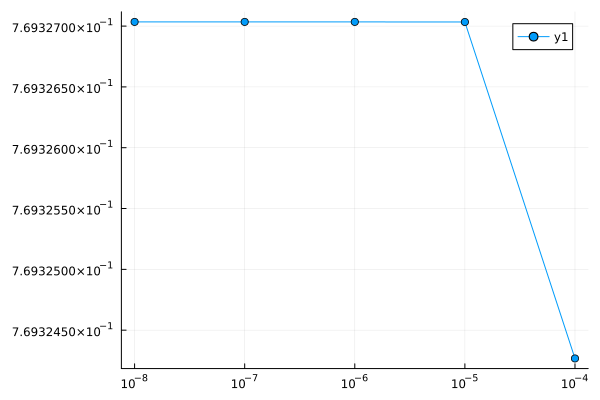

In [5]:
expvals = discard(expvals, 0.001)
plot(trunc_coeffs[1:length(expvals)], expvals, markershape=:circle, xscale=:log10)

In [6]:

df = DataFrame(x = trunc_coeffs[1:length(expvals)], y = expvals)
ols = lm(@formula(y ~ x), df)
zte_em(x) = coef(ols)[1] + coef(ols)[2] * x
corrected = zte_em(0)

0.7693271075700161

In [7]:
df

Row,x,y
,Float64,Float64
1,1.0e-8,0.769327
2,1.0e-7,0.769327
3,1.0e-6,0.769327
4,1.0e-5,0.769327
5,0.0001,0.769324


In [8]:
# Plots.default(show = true)
# gr()
# function correcting_min_abs_coeff(ansatz; exponent_min=-6, exponent_max=-1, threshold=0.01, plotting=false, n=50)
#     exponents = range(exponent_min, exponent_max, n)
#     trunc_coeffs = 10.0 .^exponents 
#     expvals = Vector{Float64}()
#     for t in trunc_coeffs
#         expval_t = trotter_time_evolution(trotter; min_abs_coeff = t, record = false)
#         push!(expvals, expval_t)
#     end
#     clean_expvals = discard(expvals, threshold)
#     clean_trunc_coeffs = trunc_coeffs[1:length(clean_expvals)]

    
#     exact_expval = trotter_time_evolution(trotter; min_abs_coeff = 0, record = false)

#     df = DataFrame(x = clean_trunc_coeffs, y = clean_expvals)
#     ols = lm(@formula(y ~ x), df)
#     zte_em(x) = coef(ols)[1] + coef(ols)[2] * x
#     corrected_expval = zte_em(0)
#     if plotting
#         # println(length(trunc_coeffs), length(expvals), length(clean_trunc_coeffs), length(clean_expvals))
#         # println(trunc_coeffs, expvals, clean_trunc_coeffs, clean_expvals)
#         p = plot(trunc_coeffs, expvals, markershape=:circle, xscale=:log10)
#         scatter!(clean_trunc_coeffs, clean_expvals, markershape=:circle, xscale=:log10)#, show=true)
#         xlabel!("truncation")
#         ylabel!("expectation value")
#         display(p)
#     end

#     return exact_expval, corrected_expval, abs(exact_expval-corrected_expval)/exact_expval, abs(exact_expval-clean_expvals[1])/exact_expval, length(clean_expvals)
# end

In [9]:

# nq = 128
# steps = 12
# T = 0.5 
# J = 2.0
# h = 1.0

# trotter = trotter_setup(nq, steps, T, J, h);

# correcting_min_abs_coeff(trotter; exponent_min=-5, plotting=true)

In [10]:
Plots.default(show = true)
gr()

function expvals_trunc_levels(ansatz, trunc_type::Symbol; trunc1=-6, trunc2=-1, threshold=0.01, n=50)
    if trunc_type==:min_abs_coeff
        exponents = range(trunc1, trunc2, n)
        trunc_coeffs = 10.0 .^exponents
    else
        trunc_coeffs = trunc1:-1:trunc2
    end
    expvals = Vector{Float64}()
    for trunc_value in trunc_coeffs
        kwargs = (; trunc_type => trunc_value)
        expval_t = trotter_time_evolution(ansatz; kwargs...)
        push!(expvals, expval_t)
    end
    clean_expvals = discard(expvals, threshold)
    clean_trunc_coeffs = trunc_coeffs[1:length(clean_expvals)]

    return clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals
end




function correcting_single_truncations(ansatz, trunc_type::Vector{Symbol}=[:min_abs_coeff]; trunc1=[-6], trunc2=[-1], threshold=0.001, plotting=false, n=50)
    corrected_expval = 0.0
    clean_trunc_coeffs_tmp, clean_expvals_tmp, trunc_coeffs_tmp, expvals_tmp = [], [], [], []
    clean_trunc_coeffs = Dict()
    clean_expvals = Dict()
    trunc_coeffs = Dict()
    expvals = Dict()
    exact_expval = trotter_time_evolution(ansatz; record = false)
    for (t, t1, t2) in zip(trunc_type, trunc1, trunc2)
        clean_trunc_coeffs_tmp, clean_expvals_tmp, trunc_coeffs_tmp, expvals_tmp = expvals_trunc_levels(ansatz, t; trunc1=t1, trunc2=t2, threshold=threshold, n=n)
        df = DataFrame(x = clean_trunc_coeffs_tmp, y = clean_expvals_tmp)
        ols = lm(@formula(y ~ x), df)
        zte_em(x) = coef(ols)[1] + coef(ols)[2] * x
        corrected_expval = zte_em(0)
        trunc_coeffs[t] = trunc_coeffs_tmp
        clean_trunc_coeffs[t] = clean_trunc_coeffs_tmp
        expvals[t] = expvals_tmp
        clean_expvals[t] = clean_expvals_tmp
        if plotting
            # println(length(trunc_coeffs_tmp), length(expvals), length(clean_trunc_coeffs_tmp_tmp), length(clean_expvals_tmp))
            # println(trunc_coeffs_tmp, expvals, clean_trunc_coeffs_tmp_tmp, clean_expvals_tmp)
    
            p = plot(trunc_coeffs_tmp, expvals_tmp, markershape=:circle, label="Data not included in the fit")
            scatter!(clean_trunc_coeffs_tmp, clean_expvals_tmp, markershape=:circle, label="Data included\nin the fit")#, show=true)
            plot!(trunc_coeffs_tmp, broadcast(abs, (expvals_tmp .-exact_expval)./exact_expval), markershape=:circle, label="Relative error for\npoints in the fit")
            scatter!(clean_trunc_coeffs_tmp, broadcast(abs, (clean_expvals_tmp .-exact_expval)./exact_expval), markershape=:circle, label="Relative error", legend=:outertopright)#, show=true)
            xlabel!("truncation")
            ylabel!("expectation value")
            title!(String(t))
            if t==:min_abs_coeff
                plot!(p, xscale=:log10)
            end
            display(p)
            println(t, " :")
            printfmt("{:.5e} {:.5e} {:.5e} {:.5e} {:.0d}\n", exact_expval, corrected_expval, abs(exact_expval-corrected_expval)/exact_expval, abs(exact_expval-clean_expvals_tmp[1])/exact_expval, length(clean_expvals))
        end
    end
    return clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals 
    # return exact_expval, corrected_expval, abs(exact_expval-corrected_expval)/exact_expval, abs(exact_expval-clean_expvals_tmp[1])/exact_expval, length(clean_expvals)
end

correcting_single_truncations (generic function with 2 methods)

In [11]:
test = Dict([("A", 3), ("B", 10)])
values(test)
length(test)

2

In [12]:

nq = 128
steps = 20
T = 1.
J = 2.0
h = 1.0

trotter = trotter_setup(nq, steps, T, J, h);

correcting_truncations(trotter, [:min_abs_coeff, :max_weight, :max_freq, :max_sins]; trunc1=[-6, 20, 50, 20], trunc2=[-1, 1, 1, 1], plotting=true);

UndefVarError: UndefVarError: `correcting_truncations` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Several truncation at a time

In [13]:
function correcting_double_truncations(ansatz, trunc_type::Vector{Symbol}=[:min_abs_coeff]; trunc1=[-6], trunc2=[-1], threshold=0.001, plotting=false, n=50)
    corrected_expval = 0.0
    clean_trunc_coeffs_tmp, clean_expvals_tmp, trunc_coeffs_tmp, expvals_tmp = [], [], [], []
    clean_trunc_coeffs = Dict()
    clean_expvals = Dict()
    trunc_coeffs = Dict()
    expvals = Dict()
    exact_expval = trotter_time_evolution(ansatz; record = false)
    for (t, t1, t2) in zip(trunc_type, trunc1, trunc2)
        clean_trunc_coeffs_tmp, clean_expvals_tmp, trunc_coeffs_tmp, expvals_tmp = expvals_noise_levels(ansatz, t; trunc1=t1, trunc2=t2, threshold=threshold, n=n)
        df = DataFrame(x = clean_trunc_coeffs_tmp, y = clean_expvals_tmp)
        ols = lm(@formula(y ~ x), df)
        zte_em(x) = coef(ols)[1] + coef(ols)[2] * x
        corrected_expval = zte_em(0)
        trunc_coeffs[t] = trunc_coeffs_tmp
        clean_trunc_coeffs[t] = clean_trunc_coeffs_tmp
        expvals[t] = expvals_tmp
        clean_expvals[t] = clean_expvals_tmp
        if plotting
            # println(length(trunc_coeffs_tmp), length(expvals), length(clean_trunc_coeffs_tmp_tmp), length(clean_expvals_tmp))
            # println(trunc_coeffs_tmp, expvals, clean_trunc_coeffs_tmp_tmp, clean_expvals_tmp)
    
            p = plot(trunc_coeffs_tmp, expvals_tmp, markershape=:circle, label="Data not included in the fit")
            scatter!(clean_trunc_coeffs_tmp, clean_expvals_tmp, markershape=:circle, label="Data included\nin the fit")#, show=true)
            plot!(trunc_coeffs_tmp, broadcast(abs, (expvals_tmp .-exact_expval)./exact_expval), markershape=:circle, label="Relative error for\npoints in the fit")
            scatter!(clean_trunc_coeffs_tmp, broadcast(abs, (clean_expvals_tmp .-exact_expval)./exact_expval), markershape=:circle, label="Relative error", legend=:outertopright)#, show=true)
            xlabel!("truncation")
            ylabel!("expectation value")
            title!(String(t))
            if t==:min_abs_coeff
                plot!(p, xscale=:log10)
            end
            display(p)
            println(t, " :")
            printfmt("{:.5e} {:.5e} {:.5e} {:.5e} {:.0d}\n", exact_expval, corrected_expval, abs(exact_expval-corrected_expval)/exact_expval, abs(exact_expval-clean_expvals_tmp[1])/exact_expval, length(clean_expvals))
        end
    end
    return clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals 
    # return exact_expval, corrected_expval, abs(exact_expval-corrected_expval)/exact_expval, abs(exact_expval-clean_expvals_tmp[1])/exact_expval, length(clean_expvals)
end

correcting_double_truncations (generic function with 2 methods)

In [14]:
collect(keys(test))

2-element Vector{String}:
 "B"
 "A"

In [15]:

function expvals_trunc_levels_double(ansatz, trunc_type; trunc1, trunc2, n=50)
    trunc_coeffs = Dict()
    for (k, t) in enumerate(trunc_type)
        if t==:min_abs_coeff
            exponents = range(trunc1[k], trunc2[k], n)
            trunc_coeffs[t] = 10.0 .^exponents
        else
            trunc_coeffs[t] = trunc1[k]:-4:trunc2[k]
        end
    end

    expvals = []

    for i in 1:length(trunc_coeffs)
        for j in i:length(trunc_coeffs)
            type1 = collect(keys(trunc_coeffs))[i]
            type2 = collect(keys(trunc_coeffs))[j]
            coeffs1 = collect(values(trunc_coeffs))[i]
            coeffs2 = collect(values(trunc_coeffs))[j]
            for coeff1 in coeffs1
                for coeff2 in coeffs2
                    kwargs = (; type1 => coeff1,  type2 => coeff2)
                    expval_t = trotter_time_evolution(ansatz; kwargs...)
                    push!(expvals, (coeff1, coeff2, expval_t))
                end
                println(coeff1, " done")
            end
        end
    end
    # clean_expvals = discard(expvals, threshold)
    # clean_trunc_coeffs = trunc_coeffs[1:length(clean_expvals)]

    # return clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals
    return expvals
end

expvals_trunc_levels_double (generic function with 1 method)

In [16]:
expvals_trunc_levels_double(trotter, (:min_abs_coeff, :max_freq); trunc1=[-6, 49], trunc2=[-1, 1], n=25)

49 done
45 done
41 done
37 done
33 done
29 done
25 done
21 done
17 done
13 done
9 done
5 done
1 done
49 done
45 done
41 done
37 done
33 done
29 done
25 done
21 done
17 done
13 done
9 done
5 done
1 done
1.0e-6 done
1.6155980984398728e-6 done
2.6101572156825386e-6 done
4.216965034285822e-6 done
6.8129206905796085e-6 done
1.1006941712522103e-5 done
1.778279410038923e-5 done
2.8729848333536626e-5 done
4.641588833612782e-5 done
7.498942093324559e-5 done
0.00012115276586285888 done
0.00019573417814876596 done
0.00031622776601683794 done
0.0005108969774506929 done
0.0008254041852680181 done
0.001333521432163324 done
0.0021544346900318843 done
0.0034807005884284095 done
0.005623413251903491 done
0.009085175756516871 done
0.014677992676220698 done
0.023713737056616554 done
0.03831186849557287 done
0.061896581889126064 done
0.1 done


1119-element Vector{Any}:
 (49, 49, 0.8739958211886867)
 (49, 45, 0.8739958211886869)
 (49, 41, 0.8739958211886869)
 (49, 37, 0.06363851511375898)
 (49, 33, 0.049715157772435535)
 (49, 29, 0.035856129432748254)
 (49, 25, 0.01060954631816662)
 (49, 21, 0.0)
 (49, 17, 0.0)
 (49, 13, 0.0)
 ⋮
 (0.1, 0.0021544346900318843, 0.818457158573429)
 (0.1, 0.0034807005884284095, 0.818457158573429)
 (0.1, 0.005623413251903491, 0.818457158573429)
 (0.1, 0.009085175756516871, 0.0)
 (0.1, 0.014677992676220698, 0.0)
 (0.1, 0.023713737056616554, 0.0)
 (0.1, 0.03831186849557287, 0.0)
 (0.1, 0.061896581889126064, 0.0)
 (0.1, 0.1, 0.0)